In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('datasets/FilteredData.csv')

In [3]:
df = data[['ClientID','CycleNumber','LengthofCycle']].copy()
df.loc[:, 'LengthofCycle'] = df['LengthofCycle'] + 1
df

,ClientID,CycleNumber,LengthofCycle
0,nfp8122,1,30
1,nfp8122,2,28
2,nfp8122,3,30
3,nfp8122,4,28
4,nfp8122,5,29
...,...,...,...
1549,nfp8334,7,30
1550,nfp8334,8,29
1551,nfp8334,9,29
1552,nfp8334,10,41


In [4]:
change_index = data.index[df['ClientID'] != df['ClientID'].shift()].to_list()
change_index.append(len(df)-1)
change_indexes = [(change_index[i-1], change_index[i]) for i in range(1,len(change_index))]

In [5]:
def hafalga_sequences_count(lengths):
    num_sequences = 0
    for start, finish in change_indexes:
        i = start + 2
        while i < finish:
            if lengths[i] == lengths[i-1] and lengths[i] == lengths[i-2]:
                num_sequences += 1
                while i < finish and lengths[i+1] == lengths[i]:
                    i += 1
            i += 1
    return num_sequences

def dilug_sequences_count(lengths):
    num_sequences = 0
    for start, finish in change_indexes:
        i = start + 2
        while i < finish:
            if lengths[i] - lengths[i-1] == lengths[i-1] - lengths[i-2] and lengths[i] - lengths[i-1] != 0:
                num_sequences += 1
                while i < finish and lengths[i+1] - lengths[i] == lengths[i] - lengths[i-1]:
                    i += 1
            i += 1
    return num_sequences

def week_sequences_count(lengths):
    weekdays_lenghts = [i for i in range(df['LengthofCycle'].min()+3,df['LengthofCycle'].max()+1,7)]
    num_sequences = 0
    for start, finish in change_indexes:
        i = start + 1
        while i < finish:
            if lengths[i] in weekdays_lenghts and lengths[i] == lengths[i-1]:
                num_sequences += 1
                while i < finish and lengths[i+1] == lengths[i]:
                    i += 1
            i += 1
    return num_sequences

def week_dilug_sequences_count(lengths):
    weekdays_lenghts = [30]
    num_sequences = 0
    for start, finish in change_indexes:
        i = start + 1
        while i < finish:
            if lengths[i] in weekdays_lenghts and lengths[i] == lengths[i-1]:
                num_sequences += 1
                while i < finish and lengths[i+1] == lengths[i]:
                    i += 1
            i += 1
    return num_sequences


$$ b_n = a_n - a_{n-1} $$
$$ d_n = b_n - b_{n-1} $$
$$ f_n = a_{n-1} + b_{n-1} + d $$

In [6]:
def dilug_in_dilug_sequences_count(lengths):
    num_sequences = 0
    for start, finish in change_indexes:
        i = start + 3      
        while i < finish:
            b1, b2, b3 = lengths[i-2] - lengths[i-3], lengths[i-1] - lengths[i-2], lengths[i] - lengths[i-1]
            d1, d2 = b2 - b1, b3 - b2
            if d1 == d2 and d1 != 0:
                num_sequences += 1
                b, d = b3, d2
                while i + 1 < finish and lengths[i+1] == lengths[i] + b + d:
                    i += 1
                    b += d
            i += 1
    return num_sequences

In [7]:
x = df['LengthofCycle'].copy()
original_frequencies = np.array([hafalga_sequences_count(x), dilug_sequences_count(x), week_sequences_count(x), week_dilug_sequences_count(x), dilug_in_dilug_sequences_count(x)])
original_frequencies

array([26, 61, 32, 18, 27])

In [8]:
num_permutations = 10000
np.random.seed(17)
simulations = []
for _ in range(num_permutations):
    x = np.random.permutation(df['LengthofCycle'])
    simulations.append({
        'Haflaga': hafalga_sequences_count(x),
        'Dilug': dilug_sequences_count(x),
        'Week': week_sequences_count(x),
        'Week_Dilug': week_dilug_sequences_count(x),
        'Dilug_in_Dilug': dilug_in_dilug_sequences_count(x)
    })
simulation_df = pd.DataFrame(simulations)   

In [10]:
simulation_df.mean()

Haflaga           11.3357
Dilug             48.8814
Week              27.0526
Week_Dilug        16.2268
Dilug_in_Dilug    27.1016
dtype: float64

In [11]:
mean_frequencies = simulation_df.mean().values
mean_frequencies

array([11.3357, 48.8814, 27.0526, 16.2268, 27.1016])

In [14]:
simulation_df.min()

Haflaga            2
Dilug             26
Week              13
Week_Dilug         5
Dilug_in_Dilug     8
dtype: int64

In [15]:
simulation_df.max()

Haflaga           27
Dilug             76
Week              42
Week_Dilug        29
Dilug_in_Dilug    48
dtype: int64

In [16]:
simulation_df.std(ddof=1)

Haflaga           3.252670
Dilug             6.526944
Week              4.050787
Week_Dilug        3.296066
Dilug_in_Dilug    5.036151
dtype: float64

In [17]:
differences_df = simulation_df.copy()
differences_df['distance_from_mean'] = np.linalg.norm(differences_df[['Haflaga', 'Dilug', 'Week', 'Week_Dilug', 'Dilug_in_Dilug']] - mean_frequencies, axis=1)
differences_df

,Haflaga,Dilug,Week,Week_Dilug,Dilug_in_Dilug,distance_from_mean
0,16,44,19,16,23,11.282849
1,11,49,23,14,13,14.844665
2,11,60,30,18,23,12.344654
3,13,55,26,19,21,9.286296
4,12,54,31,22,14,15.722757
...,...,...,...,...,...,...
9995,9,55,26,17,24,7.363320
9996,16,41,27,20,30,10.320498
9997,10,61,22,15,25,13.419951
9998,10,50,24,21,25,6.289188


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


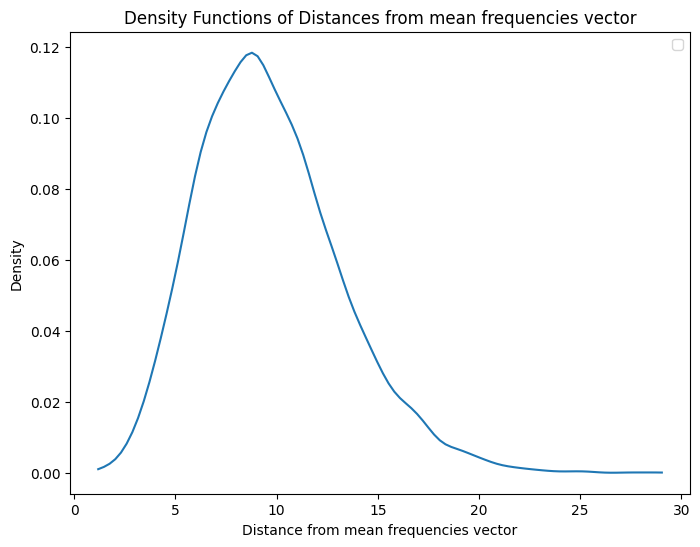

In [18]:
plt.figure(figsize=(8, 6))
distances_density = stats.gaussian_kde(differences_df['distance_from_mean'])
x_dis = np.linspace(differences_df['distance_from_mean'].min(), differences_df['distance_from_mean'].max(), 100)
plt.plot(x_dis, distances_density(x_dis))
# Set plot properties
plt.xlabel('Distance from mean frequencies vector')
plt.ylabel('Density')
plt.title('Density Functions of Distances from mean frequencies vector')
plt.legend()

# Show the plot
plt.show()


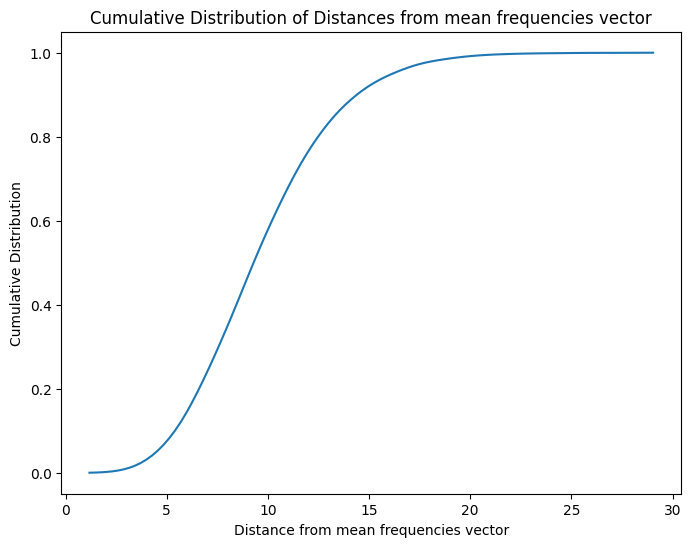

In [19]:
plt.figure(figsize=(8, 6))
distances_density = stats.gaussian_kde(differences_df['distance_from_mean'])
x_dis = np.linspace(differences_df['distance_from_mean'].min(), differences_df['distance_from_mean'].max(), 100)
cumulative = [distances_density.integrate_box_1d(differences_df['distance_from_mean'].min(), x) for x in x_dis]
plt.plot(x_dis, cumulative)
# Set plot properties
plt.xlabel('Distance from mean frequencies vector')
plt.ylabel('Cumulative Distribution')
plt.title('Cumulative Distribution of Distances from mean frequencies vector')

# Show the plot
plt.show()

In [20]:
distance_original_to_mean = np.linalg.norm(original_frequencies - mean_frequencies)
distance_original_to_mean

19.736602747433512

In [21]:
percentile = np.searchsorted(np.sort(differences_df['distance_from_mean']), distance_original_to_mean, side='right') / len(differences_df['distance_from_mean'])
percentile

0.9909